# USGS API Testing

In [1]:
import requests
import os
import copy
import random

from PIL import Image
from io import BytesIO

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

## Get API key using credentials

In [8]:
#os.environ['API_USER'] = 'aaaa'
#os.environ['API_PASSWORD'] = 'aaaa'

username = os.environ.get('API_USER')
password = os.environ.get('API_PASSWORD')

login_response = requests.post('https://m2m.cr.usgs.gov/api/api/json/stable/login', json = {"username": username, "password": password})
auth_code = login_response.json()['data']

print(f'{login_response.status_code=}')
print(f'{login_response.json()["errorCode"]=}')
print(f'{login_response.json()["errorMessage"]=}')

login_response.status_code=200
login_response.json()["errorCode"]=None
login_response.json()["errorMessage"]=None


## Search for scenes

In [10]:

payload = { 
    "datasetName": "landsat_ard_tile_c2" ,
    "metadataType": "full",
    "maxResults": 10,
    "sceneFilter": {
        # "metadataFilter": {
        #     "filterType": "and",
        #     "childFilters": [
        #         {
        #             "filterId": "60fae0a7c8a89a4d",
        #             "filterType": "value",
        #             "operand": "=",
        #             "value": 29
        #         },
        #         {
        #             "filterId": "60fae0a7a86061f5",
        #             "filterType": "value",
        #             "operand": "=",
        #             "value": 7
        #         }
        #     ]
        # },
        "acquisitionFilter": {
            "start": "2018-01-01",
            "end": "2023-01-01"
        },
        "cloudCoverFilter": {
            "max": 3,
            "min": 0,
            "includeUnknown": False
        },
        "spatialFilter": {
           "filterType": "mbr",
           "lowerLeft": {
                   "latitude": 39.92817,
                   "longitude": -74.66431
           },
           "upperRight": {
                   "latitude": 41.54334,
                   "longitude": -72.50449
           }
        }
    }
}

search_response = requests.post('https://m2m.cr.usgs.gov/api/api/json/stable/scene-search', json = payload, headers={"X-Auth-Token": auth_code})

print(f'{search_response.status_code=}')
print(f'{search_response.json()["errorCode"]=}')
print(f'{search_response.json()["errorMessage"]=}')

search_response_json_data = search_response.json()['data']

search_response.status_code=200
search_response.json()["errorCode"]=None
search_response.json()["errorMessage"]=None


### Clean response and convert to DF

In [11]:
search_response_results = search_response_json_data['results']

# unpack metadata , flatten browse field
meta_info = []
for response in search_response_results:

    for meta in response['metadata']:
        meta_info.append({'fieldName': meta['fieldName'], 'id': meta['id'], 'dictionaryLink': meta['dictionaryLink']})
        response['meta.' + meta['fieldName']] = meta['value']
    del response['metadata']

    for idx, b in enumerate(response['browse']):
        response[f'browse_{idx}'] = b
    del response['browse']

meta_info_df = pd.DataFrame.from_records(meta_info).drop_duplicates()
meta_info_df.to_csv("../data/input/api/metadata_info.csv", index = False)

search_response_results_df = pd.DataFrame.from_records(
    pd.json_normalize(search_response_results, sep=".").to_dict(orient='records')
    ).sort_values(by=['cloudCover'])
search_response_results_df.to_csv("../data/input/api/scene-search-responses.csv", index = False)

In [12]:
search_response_results_df.head()

,cloudCover,entityId,displayId,orderingId,hasCustomizedMetadata,publishDate,meta.Tile Identifier,meta.Acquisition Date,meta.Tile Grid Region,meta.Tile Grid Horizontal,...,spatialCoverage.coordinates,temporalCoverage.endDate,temporalCoverage.startDate,browse_0.id,browse_0.browseRotationEnabled,browse_0.browseName,browse_0.browsePath,browse_0.overlayPath,browse_0.overlayType,browse_0.thumbnailPath
0,0,LC08_CU_030007_20221230_20230114_02,LC08_CU_030007_20221230_20230114_02,None,None,2023-01-13 19:40:02-06,LC08_CU_030007_20221230_20230114_02,2022/12/30,CU,30,...,"[[[-72.93785, 39.59481], [-70.7642, 39.59481],...",2022-12-30 00:00:00,2022-12-30 00:00:00,60fac014d0e80a74,None,Reflective Browse,https://landsatlook.usgs.gov/gen-browse?size=r...,https://landsatlook.usgs.gov/dynamic-tiler/sce...,ls_chs,https://landsatlook.usgs.gov/gen-browse?size=t...
1,0,LC08_CU_030008_20221230_20230114_02,LC08_CU_030008_20221230_20230114_02,None,None,2023-01-13 19:40:02-06,LC08_CU_030008_20221230_20230114_02,2022/12/30,CU,30,...,"[[[-73.35581, 38.3009], [-71.22678, 38.3009], ...",2022-12-30 00:00:00,2022-12-30 00:00:00,60fac014d0e80a74,None,Reflective Browse,https://landsatlook.usgs.gov/gen-browse?size=r...,https://landsatlook.usgs.gov/dynamic-tiler/sce...,ls_chs,https://landsatlook.usgs.gov/gen-browse?size=t...
2,0,LC09_CU_030008_20221229_20230103_02,LC09_CU_030008_20221229_20230103_02,None,None,2023-01-03 04:40:03-06,LC09_CU_030008_20221229_20230103_02,2022/12/29,CU,30,...,"[[[-73.35581, 38.3009], [-71.22678, 38.3009], ...",2022-12-29 00:00:00,2022-12-29 00:00:00,60fac014d0e80a74,None,Reflective Browse,https://landsatlook.usgs.gov/gen-browse?size=r...,https://landsatlook.usgs.gov/dynamic-tiler/sce...,ls_chs,https://landsatlook.usgs.gov/gen-browse?size=t...
3,0,LC08_CU_029008_20221228_20230107_02,LC08_CU_029008_20221228_20230107_02,None,None,2023-01-06 23:40:03-06,LC08_CU_029008_20221228_20230107_02,2022/12/28,CU,29,...,"[[[-75.05315, 38.62828], [-72.93785, 38.62828]...",2022-12-28 00:00:00,2022-12-28 00:00:00,60fac014d0e80a74,None,Reflective Browse,https://landsatlook.usgs.gov/gen-browse?size=r...,https://landsatlook.usgs.gov/dynamic-tiler/sce...,ls_chs,https://landsatlook.usgs.gov/gen-browse?size=t...
6,0,LC08_CU_029008_20221221_20221231_02,LC08_CU_029008_20221221_20221231_02,None,None,2022-12-30 22:25:03-06,LC08_CU_029008_20221221_20221231_02,2022/12/21,CU,29,...,"[[[-75.05315, 38.62828], [-72.93785, 38.62828]...",2022-12-21 00:00:00,2022-12-21 00:00:00,60fac014d0e80a74,None,Reflective Browse,https://landsatlook.usgs.gov/gen-browse?size=r...,https://landsatlook.usgs.gov/dynamic-tiler/sce...,ls_chs,https://landsatlook.usgs.gov/gen-browse?size=t...


<Axes: title={'center': 'distribution of scenes from request for 1000 between 2018-2022'}, xlabel='date', ylabel='count'>

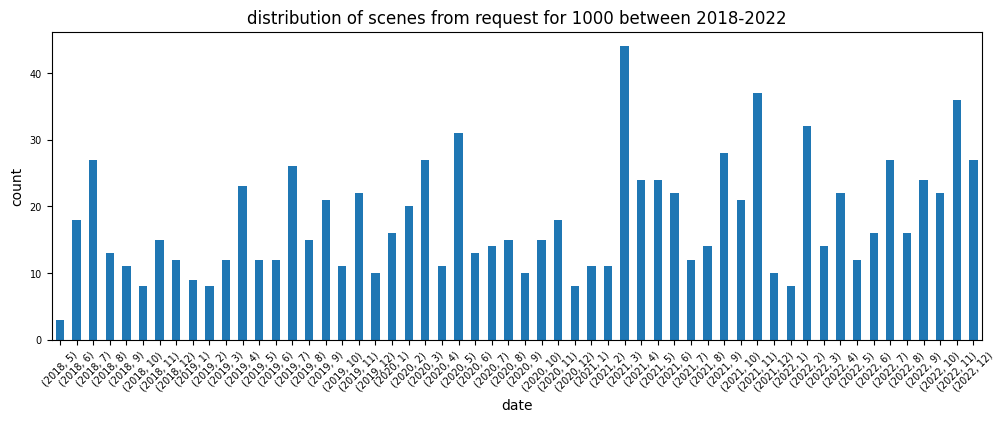

In [5]:
search_response_results_df["meta.Acquisition Date"] = search_response_results_df["meta.Acquisition Date"].astype("datetime64")
search_response_results_df.loc[:, "meta.Acquisition Date"].groupby(
    [search_response_results_df["meta.Acquisition Date"].dt.year, search_response_results_df["meta.Acquisition Date"].dt.month]
    ).count().plot(kind='bar', fontsize = '7', rot=45, figsize=(12, 4), xlabel='date', ylabel='count', title = 'distribution of scenes from request for 1000 between 2018-2022')

### Plot some of the images

In [22]:
# get image data

img_list = []
for i in range(0, 10):

    url = search_response_results_df['browse_0.browsePath'][i]
    img_response = requests.get(url)

    img = Image.open(BytesIO(img_response.content)).convert('RGB')
    img = img.resize((300,300))
    img = np.asarray(img)
    
    img_list.append(img)

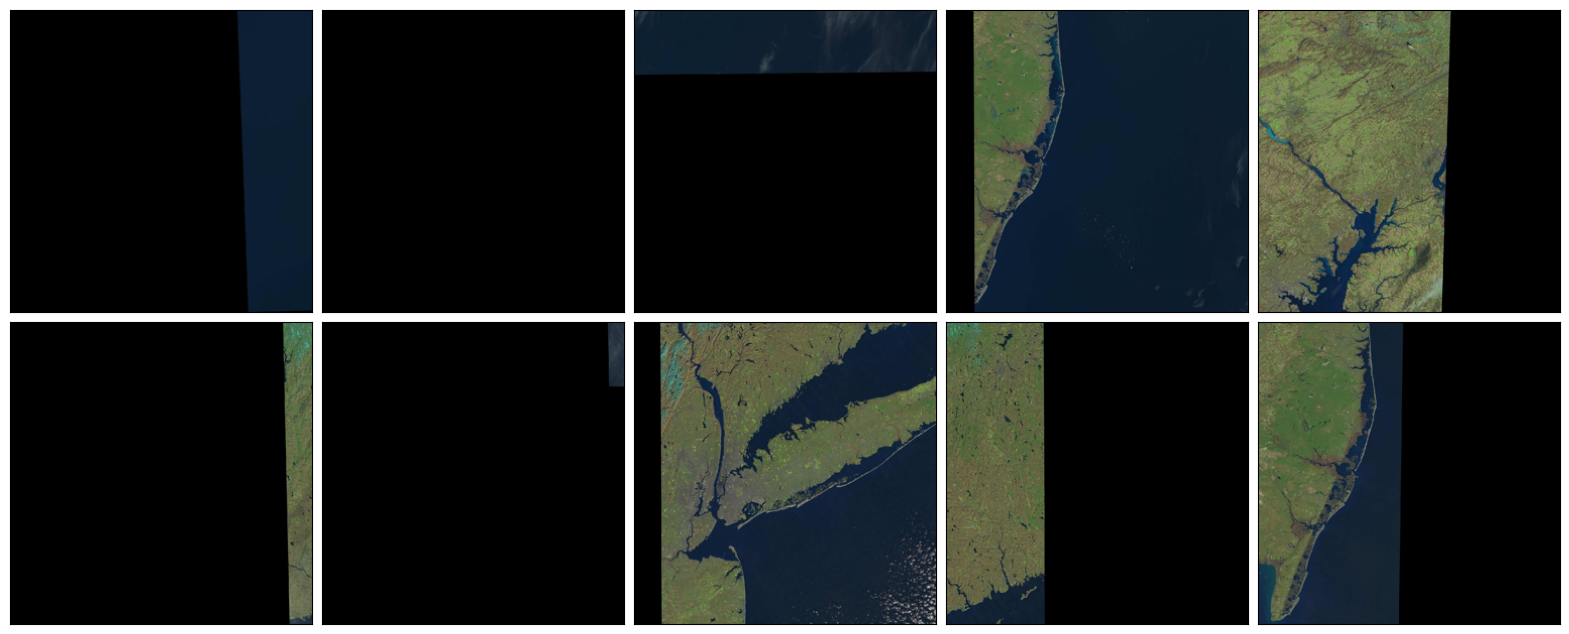

In [23]:
# plot

fig = plt.figure(figsize=(20, 20))
grid = ImageGrid(fig, 111, 
                 nrows_ncols=(2, 5),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes
                 )

for ax, im in zip(grid, img_list):
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### Collect IDs for download

In [7]:
entityIds = []
for response in search_response_results:
    entityIds.append(response['entityId'])
entityIds = list(set(entityIds))

## Get download options from API 

In [8]:
payload = {'datasetName' : 'landsat_ard_tile_c2', 'entityIds' : random.sample(entityIds, 100)}
                            
options_response = requests.post('https://m2m.cr.usgs.gov/api/api/json/stable/download-options', json = payload, headers={"X-Auth-Token": auth_code})
options_reponse_data = options_response.json()['data']

print(f'{options_response.status_code=}')
print(f'{options_response.json()["errorCode"]=}')
print(f'{options_response.json()["errorMessage"]=}')

options_response.status_code=200
options_response.json()["errorCode"]=None
options_response.json()["errorMessage"]=None


### Clean/flatten response and convert to DF

In [9]:
flatter_options_response_data = []
for record in options_reponse_data:
    for secondary in record['secondaryDownloads']:

        copy_record = copy.deepcopy(record)
        copy_record['secondaryDownloads'] = secondary
        
        flatter_options_response_data.append(copy_record)

options_response_df = pd.DataFrame.from_records(
    pd.json_normalize(flatter_options_response_data, sep=".").to_dict(orient='records')
    )
options_response_df.to_csv("../data/input/api/download-options-responses.csv", index = False)

In [10]:
options_response_df.head()

,id,displayId,entityId,datasetId,available,filesize,productName,productCode,bulkAvailable,downloadSystem,...,secondaryDownloads.displayId,secondaryDownloads.entityId,secondaryDownloads.datasetId,secondaryDownloads.available,secondaryDownloads.filesize,secondaryDownloads.productName,secondaryDownloads.productCode,secondaryDownloads.bulkAvailable,secondaryDownloads.downloadSystem,secondaryDownloads.secondaryDownloads
0,60fabcf869134f9f,LC08_CU_028006_20200915_20210504_02,LC08_CU_028006_20200915_20210504_02,60e70a51afdadbb1,True,2078298,C2 ARD Tile Quality Assessment Bundle Download,D777,True,ls_zip,...,LC08_CU_028006_20200915_20210504_02_QA_LINEAGE...,LC08_CU_028006_20200915_20210504_02_QA_LINEAGE...,60e86562f75a5b63,True,72299,C2 ARD Tile Band Download,D771,True,ls_ard_s3,[]
1,60fabcf869134f9f,LC08_CU_028006_20200915_20210504_02,LC08_CU_028006_20200915_20210504_02,60e70a51afdadbb1,True,2078298,C2 ARD Tile Quality Assessment Bundle Download,D777,True,ls_zip,...,LC08_CU_028006_20200915_20210504_02_QA_PIXEL.TIF,LC08_CU_028006_20200915_20210504_02_QA_PIXEL.TIF,60e86562f75a5b63,True,1909114,C2 ARD Tile Band Download,D771,True,ls_ard_s3,[]
2,60fabcf869134f9f,LC08_CU_028006_20200915_20210504_02,LC08_CU_028006_20200915_20210504_02,60e70a51afdadbb1,True,2078298,C2 ARD Tile Quality Assessment Bundle Download,D777,True,ls_zip,...,LC08_CU_028006_20200915_20210504_02_QA_RADSAT.TIF,LC08_CU_028006_20200915_20210504_02_QA_RADSAT.TIF,60e86562f75a5b63,True,96885,C2 ARD Tile Band Download,D771,True,ls_ard_s3,[]
3,60fabcf8fa08feea,LC08_CU_028006_20200915_20210504_02,LC08_CU_028006_20200915_20210504_02,60e70a51afdadbb1,True,70656,C2 ARD Tile Metadata Bundle Download,D772,True,ls_zip,...,LC08_CU_028006_20200915_20210504_02.json,LC08_CU_028006_20200915_20210504_02.json,60e86562f75a5b63,True,56903,C2 ARD Tile Band Download,D771,True,ls_ard_s3,[]
4,60fabcf8fa08feea,LC08_CU_028006_20200915_20210504_02,LC08_CU_028006_20200915_20210504_02,60e70a51afdadbb1,True,70656,C2 ARD Tile Metadata Bundle Download,D772,True,ls_zip,...,LC08_CU_028006_20200915_20210504_02.xml,LC08_CU_028006_20200915_20210504_02.xml,60e86562f75a5b63,True,70656,C2 ARD Tile Band Download,D771,True,ls_ard_s3,[]


In [9]:
# what are the bundle names?
options_response_df['productName'].unique()

array(['C2 ARD Tile Quality Assessment Bundle Download',
       'C2 ARD Tile Metadata Bundle Download',
       'C2 ARD Tile Surface Reflectance Bundle Download',
       'C2 ARD Tile Surface Temperature Bundle Download',
       'C2 ARD Tile Top of Atmosphere Reflectance Bundle Download',
       'C2 ARD Tile Brightness Temperature Bundle Download'], dtype=object)

### Filter download options for 'available'

In [11]:
avail_options_response_df = options_response_df[options_response_df['available']]

## Use API to request download information

In [12]:
# filter for available downloads
avail_options_response_df = avail_options_response_df.rename(columns={"id": "productId"})

codes_df = avail_options_response_df[['entityId', 'productId']].drop_duplicates()
codes_dict = codes_df.to_dict('records')

label = "download-test"
payload = {'downloads' : codes_dict, 'label' : label}

download_response = requests.post('https://m2m.cr.usgs.gov/api/api/json/stable/download-request', json = payload, headers={"X-Auth-Token": auth_code})
download_response_data = download_response.json()['data']

print(f'{download_response.status_code=}')
print(f'{download_response.json()["errorCode"]=}')
print(f'{download_response.json()["errorMessage"]=}')


download_response.status_code=200
download_response.json()["errorCode"]=None
download_response.json()["errorMessage"]=None


### Count responses and check for failures or pending downloads

In [13]:
count_responses = {k: len(download_response_data[k]) for k in ['availableDownloads', 'duplicateProducts', 'preparingDownloads', 'failed', 'newRecords']}
print(count_responses)

{'availableDownloads': 600, 'duplicateProducts': 0, 'preparingDownloads': 0, 'failed': 0, 'newRecords': 600}


In [14]:
download_response_data['numInvalidScenes']

0

## Save download information DF

In [15]:
download_response_df = pd.DataFrame.from_dict(download_response_data['availableDownloads'])

# pull out entityId from URL
download_response_df[['downloadEntity', 'entityType']] = download_response_df['url'].str.extract(r'.*landsat_product_id=(.*)_(.*)&.*')

# pivot df
download_response_df = download_response_df.pivot(index = ['downloadEntity'], columns=['entityType'], values=['url', 'downloadId'])
download_response_df.columns = ["_".join(tup) for tup in download_response_df.columns.to_flat_index()]

download_response_df.to_csv('../data/input/api/downloads-request-reponses.csv')

In [16]:
download_response_df.head()

,url_BT,url_MTL,url_QA,url_SR,url_ST,url_TOA,downloadId_BT,downloadId_MTL,downloadId_QA,downloadId_SR,downloadId_ST,downloadId_TOA
downloadEntity,,,,,,,,,,,,
LC08_CU_028006_20200915_20210504_02,https://landsatlook.usgs.gov/gen-bundle?landsa...,https://landsatlook.usgs.gov/gen-bundle?landsa...,https://landsatlook.usgs.gov/gen-bundle?landsa...,https://landsatlook.usgs.gov/gen-bundle?landsa...,https://landsatlook.usgs.gov/gen-bundle?landsa...,https://landsatlook.usgs.gov/gen-bundle?landsa...,367976064,367976060,367976059,367976061,367976062,367976063
LC08_CU_028006_20220322_20220402_02,https://landsatlook.usgs.gov/gen-bundle?landsa...,https://landsatlook.usgs.gov/gen-bundle?landsa...,https://landsatlook.usgs.gov/gen-bundle?landsa...,https://landsatlook.usgs.gov/gen-bundle?landsa...,https://landsatlook.usgs.gov/gen-bundle?landsa...,https://landsatlook.usgs.gov/gen-bundle?landsa...,367976071,367976067,367976065,367976068,367976069,367976070
LC08_CU_028007_20210630_20210711_02,https://landsatlook.usgs.gov/gen-bundle?landsa...,https://landsatlook.usgs.gov/gen-bundle?landsa...,https://landsatlook.usgs.gov/gen-bundle?landsa...,https://landsatlook.usgs.gov/gen-bundle?landsa...,https://landsatlook.usgs.gov/gen-bundle?landsa...,https://landsatlook.usgs.gov/gen-bundle?landsa...,367976077,367976073,367976072,367976074,367976075,367976076
LC08_CU_028007_20221108_20221118_02,https://landsatlook.usgs.gov/gen-bundle?landsa...,https://landsatlook.usgs.gov/gen-bundle?landsa...,https://landsatlook.usgs.gov/gen-bundle?landsa...,https://landsatlook.usgs.gov/gen-bundle?landsa...,https://landsatlook.usgs.gov/gen-bundle?landsa...,https://landsatlook.usgs.gov/gen-bundle?landsa...,367976083,367976079,367976078,367976080,367976081,367976082
LC08_CU_028008_20190727_20210504_02,https://landsatlook.usgs.gov/gen-bundle?landsa...,https://landsatlook.usgs.gov/gen-bundle?landsa...,https://landsatlook.usgs.gov/gen-bundle?landsa...,https://landsatlook.usgs.gov/gen-bundle?landsa...,https://landsatlook.usgs.gov/gen-bundle?landsa...,https://landsatlook.usgs.gov/gen-bundle?landsa...,367976090,367976085,367976084,367976086,367976087,367976088


## Logout

In [18]:
logout_response = requests.post('https://m2m.cr.usgs.gov/api/api/json/stable/logout',  headers={"X-Auth-Token": auth_code})

print(f'{logout_response.status_code=}')
print(f'{logout_response.json()["errorCode"]=}')
print(f'{logout_response.json()["errorMessage"]=}')

logout_response.status_code=200
logout_response.json()["errorCode"]=None
logout_response.json()["errorMessage"]=None
